<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>

</div>

In [ ]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F

import torch.distributions

# Latent dimensions
z = 10
# Training iterations
iter_max =50 #200
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    # Create pre-processed training and test sets
    X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.train_labels.to(device)
    X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    y_test = test_loader.dataset.test_labels.to(device)

    return train_loader,test_loader, (X_test, y_test)

train_loader, _,_ = get_mnist_data(device, batch_size)
_,test_loader,_ = get_mnist_data(device, batch_size)
_,_,(X_test, y_test)=get_mnist_data(device, batch_size)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """

    # Sample z
    N=torch.distributions.Normal(0, 1)
    N.loc = N.loc.cuda()
    N.scale = N.scale.cuda()
    z = m + torch.sqrt(v)*N.sample(m.shape)
    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=-1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=-1)
        return self.net(zy)


In [ ]:

# Note that:  if y_dim==0 this is VAE, otherwise this is CVAE.
class VAE(nn.Module):
    def __init__(self, name='vae', z_dim=2, y_dim=0, Beta=1):
        super().__init__()
        self.name = name
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.Beta=Beta

        self.enc = Encoder(self.z_dim,self.y_dim)
        self.dec = Decoder(self.z_dim,self.y_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_elbo_bound(self, x, y=None):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        # Computing negative Evidence Lower Bound and its KL and Reconstruction term
        # Note that nelbo = kl + rec
        m, v = self.enc.encode(x,y)
        kl= kl_normal(m,v,pm=torch.zeros(1).expand(self.z_dim).cuda(),pv=torch.ones(1).expand(self.z_dim).cuda())*self.Beta
        kl=torch.mean(kl)
        z = sample_gaussian(m, v)
        logits= self.dec.decode(z,y)
        rec= -log_bernoulli_with_logits(x, logits)
        rec=torch.mean(rec)
        nelbo= kl+rec
        return nelbo, kl, rec


    def loss(self, x, y=None):
        nelbo, kl, rec = self.negative_elbo_bound(x,y)
        loss = nelbo
        summaries = dict((
            ('train/loss', nelbo),
            ('gen/elbo', -nelbo),
            ('gen/kl_z', kl),
            ('gen/rec', rec),
        ))
        return loss, summaries


    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


In [ ]:
cvae = VAE(z_dim=z, y_dim=10, Beta=1).to(device)
#Note that since y_dim is not 0, so this is CVAE.
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
nelbo_1=torch.zeros(1,50)
kl_1=torch.zeros(1,50)
rec_1=torch.zeros(1,50)
nelbo_test_1=torch.zeros(1,50)
kl_test_1=torch.zeros(1,50)
rec_test_1=torch.zeros(1,50)

for i in tqdm(range(iter_max)):
    for batch_idx, (xu, yu) in enumerate(train_loader):

        optimizer.zero_grad()

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = cvae.loss(xu,yu)
        nelbo_1[0][i]=loss
        kl_1[0][i]=summaries['gen/kl_z']
        rec_1[0][i]=summaries['gen/rec']
        loss.backward()
        optimizer.step()

    print('nelbo: ', summaries['train/loss'],'kl: ',summaries['gen/kl_z'],'rec: ',summaries['gen/rec'])
    with torch.no_grad():
      for batch_idx_test, (xu_test, yu_test) in enumerate(test_loader):

        optimizer.zero_grad()

        xu_test = torch.bernoulli(xu_test.to(device).reshape(xu_test.size(0), -1))
        yu_test = yu_test.new(np.eye(10)[yu_test]).to(device).float()
        loss_test, summaries_test = cvae.loss(xu_test,yu_test)

        nelbo_test_1[0][i]=loss_test
        kl_test_1[0][i]=summaries_test['gen/kl_z']
        rec_test_1[0][i]=summaries_test['gen/rec']

  0%|          | 0/50 [00:00<?, ?it/s]

nelbo:  tensor(118.2541, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(12.6897, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(105.5644, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 1/50 [00:09<07:39,  9.37s/it]

nelbo:  tensor(113.7184, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(15.1104, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(98.6080, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 2/50 [00:17<07:03,  8.81s/it]

nelbo:  tensor(110.7064, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.2138, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(94.4927, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 3/50 [00:26<06:48,  8.68s/it]

nelbo:  tensor(107.0934, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.0195, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(91.0739, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 4/50 [00:37<07:21,  9.59s/it]

nelbo:  tensor(100.9677, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(15.7321, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(85.2356, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 5/50 [00:45<06:56,  9.26s/it]

nelbo:  tensor(109.9402, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.4446, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(93.4956, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 6/50 [00:56<07:10,  9.78s/it]

nelbo:  tensor(104.6999, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(15.8725, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(88.8274, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 7/50 [01:06<07:05,  9.91s/it]

nelbo:  tensor(101.7290, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.3394, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(85.3896, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 8/50 [01:17<07:10, 10.25s/it]

nelbo:  tensor(99.9292, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(15.9558, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(83.9734, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 9/50 [01:26<06:38,  9.71s/it]

nelbo:  tensor(100.4064, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(15.9469, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(84.4594, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 10/50 [01:35<06:20,  9.51s/it]

nelbo:  tensor(96.0571, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.1438, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.9133, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 11/50 [01:43<05:58,  9.18s/it]

nelbo:  tensor(98.6049, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.4856, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(82.1194, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 12/50 [01:52<05:40,  8.96s/it]

nelbo:  tensor(94.9399, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.0879, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.8520, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 13/50 [02:01<05:31,  8.96s/it]

nelbo:  tensor(96.1566, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.1314, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.0251, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 14/50 [02:09<05:16,  8.80s/it]

nelbo:  tensor(99.6209, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.7480, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(82.8729, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 15/50 [02:18<05:04,  8.70s/it]

nelbo:  tensor(95.3597, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.3800, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.9797, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 16/50 [02:27<05:01,  8.85s/it]

nelbo:  tensor(92.5597, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.0122, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.5475, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 17/50 [02:35<04:47,  8.72s/it]

nelbo:  tensor(92.1780, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.0650, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.1130, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 18/50 [02:45<04:42,  8.84s/it]

nelbo:  tensor(95.7797, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.4737, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.3059, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 19/50 [02:53<04:31,  8.74s/it]

nelbo:  tensor(97.9389, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.9554, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.9835, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 20/50 [03:02<04:23,  8.77s/it]

nelbo:  tensor(95.3983, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.1810, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.2172, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 21/50 [03:10<04:11,  8.66s/it]

nelbo:  tensor(94.8906, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.2947, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.5959, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 22/50 [03:19<04:05,  8.78s/it]

nelbo:  tensor(92.0261, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(15.9706, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.0554, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 23/50 [03:29<04:02,  8.98s/it]

nelbo:  tensor(95.4105, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.2486, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.1619, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 24/50 [03:37<03:49,  8.82s/it]

nelbo:  tensor(96.7179, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.9666, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.7514, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 25/50 [03:46<03:37,  8.70s/it]

nelbo:  tensor(96.6894, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.7350, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.9545, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 26/50 [03:54<03:26,  8.62s/it]

nelbo:  tensor(96.5053, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.7268, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.7785, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 27/50 [04:02<03:17,  8.57s/it]

nelbo:  tensor(98.0151, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.3406, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.6745, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 28/50 [04:11<03:07,  8.53s/it]

nelbo:  tensor(93.4556, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.7008, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.7548, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 29/50 [04:20<03:01,  8.66s/it]

nelbo:  tensor(97.3010, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.7127, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.5883, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 30/50 [04:28<02:52,  8.63s/it]

nelbo:  tensor(92.6893, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.4535, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.2358, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 31/50 [04:37<02:42,  8.57s/it]

nelbo:  tensor(96.4400, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.5589, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.8811, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 32/50 [04:45<02:33,  8.53s/it]

nelbo:  tensor(99.6336, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.7202, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(82.9134, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 33/50 [04:54<02:25,  8.54s/it]

nelbo:  tensor(96.5815, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.0506, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.5309, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 34/50 [05:03<02:18,  8.69s/it]

nelbo:  tensor(95.0901, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.7971, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.2930, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 35/50 [05:11<02:08,  8.58s/it]

nelbo:  tensor(86.0983, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.3723, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(69.7261, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 36/50 [05:20<02:01,  8.71s/it]

nelbo:  tensor(98.8852, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.2557, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.6296, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 37/50 [05:29<01:52,  8.66s/it]

nelbo:  tensor(95.5352, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.9803, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.5549, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 38/50 [05:37<01:43,  8.58s/it]

nelbo:  tensor(97.9833, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.9306, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.0527, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 39/50 [05:46<01:36,  8.75s/it]

nelbo:  tensor(92.1177, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.6126, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.5051, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 40/50 [05:55<01:27,  8.72s/it]

nelbo:  tensor(91.8834, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.4229, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(74.4605, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 41/50 [06:03<01:17,  8.63s/it]

nelbo:  tensor(95.2062, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.2467, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(77.9595, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 42/50 [06:12<01:08,  8.56s/it]

nelbo:  tensor(92.3322, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.7864, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.5458, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 43/50 [06:20<00:59,  8.51s/it]

nelbo:  tensor(93.8376, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.3650, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.4726, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 44/50 [06:29<00:52,  8.71s/it]

nelbo:  tensor(92.8015, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.5619, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.2395, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 45/50 [06:38<00:43,  8.61s/it]

nelbo:  tensor(92.9598, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.0127, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.9471, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 46/50 [06:46<00:34,  8.58s/it]

nelbo:  tensor(91.5890, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.8779, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(74.7111, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 47/50 [06:55<00:25,  8.52s/it]

nelbo:  tensor(93.9803, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.8489, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(77.1314, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 48/50 [07:04<00:17,  8.66s/it]

nelbo:  tensor(97.8645, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.1027, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.7618, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 49/50 [07:13<00:08,  8.74s/it]

nelbo:  tensor(96.8171, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.0567, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.7605, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [07:21<00:00,  8.83s/it]


In [ ]:
import matplotlib.pyplot as plt
def cpred(class_number):
  z=sample_gaussian(torch.zeros(10).cuda(), torch.ones(10).cuda())
  y=torch.zeros(10)
  y[class_number]=1
  logits=cvae.dec.decode(z.cuda(),y.cuda())

  ### seeing the bluring
  X_hat=logits

  ### not seeing the bluring  ( if you want to generate images in binary erase the hashtag sign(#) at the begning of the below line)
  #X_hat=torch.bernoulli(torch.sigmoid(logits))


  X_hat=X_hat.reshape(28, 28).to('cpu').detach().numpy()
  plt.imshow(X_hat)


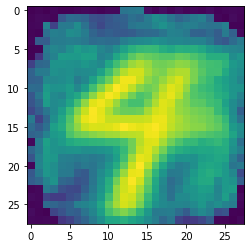

In [ ]:
cpred(4)

In [ ]:
vae = VAE(z_dim=z, y_dim=0, Beta=1).to(device)
#Note that since y_dim is 0, so this is VAE.
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
nelbo_1=torch.zeros(1,50)
kl_1=torch.zeros(1,50)
rec_1=torch.zeros(1,50)
nelbo_test_1=torch.zeros(1,50)
kl_test_1=torch.zeros(1,50)
rec_test_1=torch.zeros(1,50)

for i in tqdm(range(iter_max)):
    for batch_idx, (xu, yu) in enumerate(train_loader):

        optimizer.zero_grad()

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = vae.loss(xu)
        nelbo_1[0][i]=loss
        kl_1[0][i]=summaries['gen/kl_z']
        rec_1[0][i]=summaries['gen/rec']
        loss.backward()
        optimizer.step()

    print('nelbo: ', summaries['train/loss'],'kl: ',summaries['gen/kl_z'],'rec: ',summaries['gen/rec'])
    with torch.no_grad():
      for batch_idx_test, (xu_test, yu_test) in enumerate(test_loader):

        optimizer.zero_grad()

        xu_test = torch.bernoulli(xu_test.to(device).reshape(xu_test.size(0), -1))
        yu_test = yu_test.new(np.eye(10)[yu_test]).to(device).float()
        loss_test, summaries_test = vae.loss(xu_test)

        nelbo_test_1[0][i]=loss_test
        kl_test_1[0][i]=summaries_test['gen/kl_z']
        rec_test_1[0][i]=summaries_test['gen/rec']


  0%|          | 0/50 [00:00<?, ?it/s]

nelbo:  tensor(126.7183, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(15.8067, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(110.9115, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 1/50 [00:08<06:53,  8.43s/it]

nelbo:  tensor(116.5325, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(16.6810, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(99.8515, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 2/50 [00:17<07:02,  8.79s/it]

nelbo:  tensor(109.6000, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.3884, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(92.2116, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 3/50 [00:25<06:47,  8.66s/it]

nelbo:  tensor(110.4356, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.3152, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(93.1204, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 4/50 [00:35<06:53,  8.99s/it]

nelbo:  tensor(109.3448, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.8265, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(91.5184, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 5/50 [00:43<06:36,  8.80s/it]

nelbo:  tensor(109.8894, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(17.9886, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(91.9008, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 6/50 [00:57<07:35, 10.35s/it]

nelbo:  tensor(107.6136, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.6592, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(88.9544, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 7/50 [01:07<07:20, 10.24s/it]

nelbo:  tensor(107.1742, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.6718, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(88.5024, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 8/50 [01:18<07:19, 10.47s/it]

nelbo:  tensor(104.9897, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.4979, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(86.4918, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 9/50 [01:32<07:53, 11.55s/it]

nelbo:  tensor(105.9624, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.3343, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(87.6281, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 10/50 [01:42<07:31, 11.28s/it]

nelbo:  tensor(103.8765, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.7166, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(85.1599, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 11/50 [01:51<06:46, 10.42s/it]

nelbo:  tensor(101.2961, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.8789, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(82.4171, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 12/50 [01:59<06:12,  9.80s/it]

nelbo:  tensor(104.1635, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.9864, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(85.1770, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 13/50 [02:08<05:54,  9.58s/it]

nelbo:  tensor(96.4672, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.5191, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(77.9481, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 14/50 [02:17<05:40,  9.45s/it]

nelbo:  tensor(105.8540, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(20.0529, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(85.8010, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 15/50 [02:26<05:20,  9.16s/it]

nelbo:  tensor(97.0297, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.7187, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.3110, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 16/50 [02:35<05:14,  9.26s/it]

nelbo:  tensor(97.7150, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.7208, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.9941, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 17/50 [02:44<04:56,  8.99s/it]

nelbo:  tensor(102.5181, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.5254, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(83.9927, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 18/50 [02:53<04:48,  9.00s/it]

nelbo:  tensor(100.2166, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.0809, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.1357, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 19/50 [03:01<04:33,  8.82s/it]

nelbo:  tensor(103.5892, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.2692, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(84.3201, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 20/50 [03:10<04:26,  8.88s/it]

nelbo:  tensor(100.3667, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.6043, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.7624, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 21/50 [03:19<04:13,  8.72s/it]

nelbo:  tensor(101.6155, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.6054, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(82.0101, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 22/50 [03:27<04:01,  8.62s/it]

nelbo:  tensor(99.2180, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.1041, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.1139, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 23/50 [03:36<03:56,  8.77s/it]

nelbo:  tensor(101.6636, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.5991, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(83.0645, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 24/50 [03:45<03:45,  8.66s/it]

nelbo:  tensor(102.4552, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.3191, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(83.1361, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 25/50 [03:53<03:35,  8.61s/it]

nelbo:  tensor(99.1751, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.4611, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.7140, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 26/50 [04:02<03:29,  8.72s/it]

nelbo:  tensor(100.1763, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.9952, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.1811, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 27/50 [04:10<03:17,  8.60s/it]

nelbo:  tensor(100.9213, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.9297, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.9916, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 28/50 [04:19<03:11,  8.72s/it]

nelbo:  tensor(97.4958, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.1696, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.3262, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 29/50 [04:28<03:01,  8.63s/it]

nelbo:  tensor(102.1323, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.2003, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(82.9320, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 30/50 [04:36<02:51,  8.56s/it]

nelbo:  tensor(101.0543, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.5036, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.5507, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 31/50 [04:44<02:41,  8.50s/it]

nelbo:  tensor(99.5578, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.6424, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(79.9154, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 32/50 [04:53<02:32,  8.46s/it]

nelbo:  tensor(100.0953, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.6773, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.4180, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 33/50 [05:02<02:26,  8.61s/it]

nelbo:  tensor(103.6773, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.5933, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(84.0840, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 34/50 [05:10<02:16,  8.56s/it]

nelbo:  tensor(93.6387, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.9025, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(74.7362, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 35/50 [05:19<02:08,  8.54s/it]

nelbo:  tensor(95.9430, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.2947, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.6483, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 36/50 [05:27<01:58,  8.48s/it]

nelbo:  tensor(101.2236, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.0796, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(82.1440, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 37/50 [05:35<01:49,  8.45s/it]

nelbo:  tensor(95.5865, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(18.9462, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.6402, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 38/50 [05:44<01:43,  8.58s/it]

nelbo:  tensor(97.2486, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.4674, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(77.7812, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 39/50 [05:53<01:33,  8.51s/it]

nelbo:  tensor(101.5454, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.6907, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(81.8548, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 40/50 [06:02<01:26,  8.68s/it]

nelbo:  tensor(98.9906, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(20.0937, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.8969, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 41/50 [06:10<01:17,  8.58s/it]

nelbo:  tensor(100.3811, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.6131, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(80.7679, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 42/50 [06:19<01:08,  8.54s/it]

nelbo:  tensor(98.2162, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.3981, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.8181, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 43/50 [06:27<01:00,  8.60s/it]

nelbo:  tensor(102.5365, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.5273, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(83.0091, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 44/50 [06:36<00:51,  8.65s/it]

nelbo:  tensor(94.2416, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.0925, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(75.1490, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 45/50 [06:44<00:42,  8.55s/it]

nelbo:  tensor(93.4189, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.0591, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(74.3598, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 46/50 [06:53<00:33,  8.49s/it]

nelbo:  tensor(95.8501, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.6247, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(76.2254, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 47/50 [07:01<00:25,  8.46s/it]

nelbo:  tensor(97.5866, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.3077, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.2789, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 48/50 [07:09<00:16,  8.40s/it]

nelbo:  tensor(97.3929, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.1973, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(78.1955, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 49/50 [07:18<00:08,  8.58s/it]

nelbo:  tensor(97.7860, device='cuda:0', grad_fn=<AddBackward0>) kl:  tensor(19.9417, device='cuda:0', grad_fn=<MeanBackward0>) rec:  tensor(77.8442, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 50/50 [07:27<00:00,  8.95s/it]


In [ ]:
def vae_test():
  z=sample_gaussian(torch.zeros(10).cuda(), torch.ones(10).cuda())
  logits=vae.dec.decode(z.cuda())

  ### seeing the bluring
  X_hat=logits

  ### not seeing the bluring  ( if you want to generate images in binary erase the hashtag sign(#) at the begning of the below line)
  #X_hat=torch.bernoulli(torch.sigmoid(logits))

  X_hat=X_hat.reshape(28, 28).to('cpu').detach().numpy()
  return X_hat

### Keep sampling from VAE until obtaining digits 4, 6 and 8, each of which 3 times.

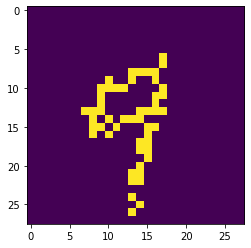

In [ ]:
a_4_1=vae.sample_x(1)
a_4_1=a_4_1.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(a_4_1)

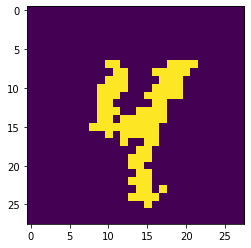

In [ ]:
a_4_2=vae.sample_x(1)
a_4_2=a_4_2.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(a_4_2)

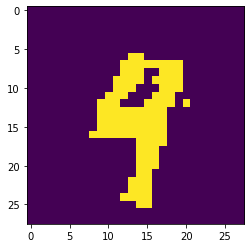

In [ ]:
a_4_3=vae.sample_x(1)
a_4_3=a_4_3.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(a_4_3)

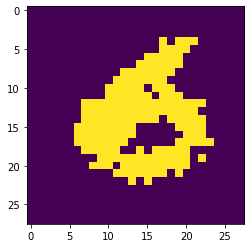

In [ ]:
a_6_1=vae.sample_x(1)
a_6_1=a_6_1.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(a_6_1)

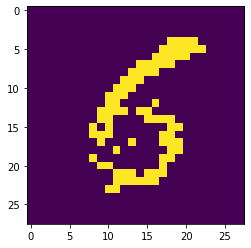

In [ ]:
a_6_2=vae.sample_x(1)
a_6_2=a_6_2.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(a_6_2)

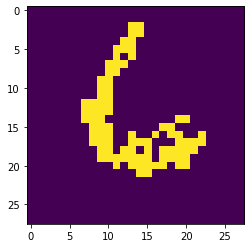

In [ ]:
a_6_3=vae.sample_x(1)
a_6_3=a_6_3.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(a_6_3)

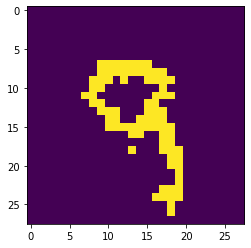

In [ ]:
a_8_1=vae.sample_x(1)
a_8_1=a_8_1.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(a_8_1)

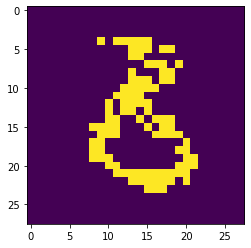

In [ ]:
a_8_2=vae.sample_x(1)
a_8_2=a_8_2.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(a_8_2)

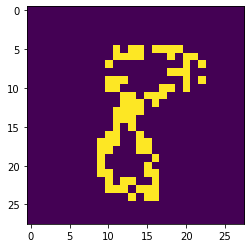

In [ ]:
a_8_3=vae.sample_x(1)
a_8_3=a_8_3.reshape(28, 28).to('cpu').detach().numpy()
plt.imshow(a_8_3)

(-0.5, 27.5, 27.5, -0.5)

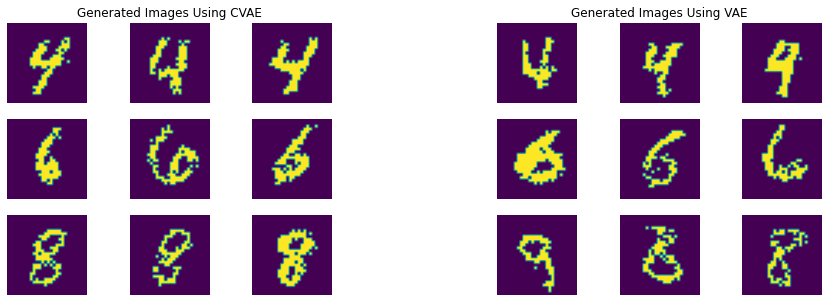

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)


plt.subplot(3,7,1)
cpred(4)
plt.axis('off')
plt.subplot(3,7,2)
cpred(4)
plt.title('Generated Images Using CVAE')
plt.axis('off')
plt.subplot(3,7,3)
cpred(4)
plt.axis('off')
plt.subplot(3,7,8)
cpred(6)
plt.axis('off')
plt.subplot(3,7,9)
cpred(6)
plt.axis('off')
plt.subplot(3,7,10)
cpred(6)
plt.axis('off')
plt.subplot(3,7,15)
cpred(8)
plt.axis('off')
plt.subplot(3,7,16)
cpred(8)
plt.axis('off')
plt.subplot(3,7,17)
cpred(8)
plt.axis('off')

plt.subplot(3,7,5)
plt.imshow(a_4_1)
plt.axis('off')
plt.subplot(3,7,6)
plt.imshow(a_4_2)
plt.title('Generated Images Using VAE')
plt.axis('off')
plt.subplot(3,7,7)
plt.imshow(a_4_3)
plt.axis('off')
plt.subplot(3,7,12)
plt.imshow(a_6_1)
plt.axis('off')
plt.subplot(3,7,13)
plt.imshow(a_6_2)
plt.axis('off')
plt.subplot(3,7,14)
plt.imshow(a_6_3)
plt.axis('off')
plt.subplot(3,7,19)
plt.imshow(a_8_1)
plt.axis('off')
plt.subplot(3,7,20)
plt.imshow(a_8_2)
plt.axis('off')
plt.subplot(3,7,21)
plt.imshow(a_8_3)
plt.axis('off')

# With Bluring(without sigmoid and bernoulli function)

###Keep sampling from VAE until obtaining digits 4, 6 and 8, each of which 3 times.

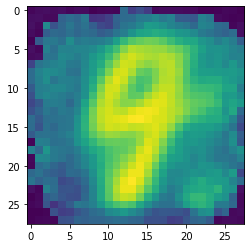

In [ ]:
a_4_1=vae_test()
plt.imshow(a_4_1)

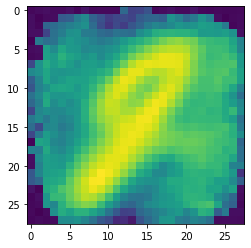

In [ ]:
a_4_2=vae_test()
plt.imshow(a_4_2)

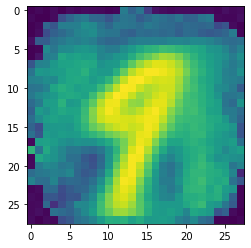

In [ ]:
a_4_3=vae_test()
plt.imshow(a_4_3)

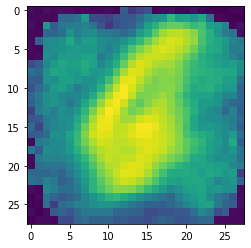

In [ ]:
a_6_1=vae_test()
plt.imshow(a_6_1)

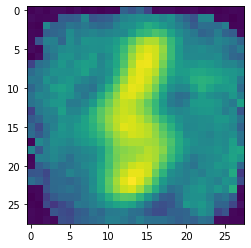

In [ ]:
a_6_2=vae_test()
plt.imshow(a_6_2)

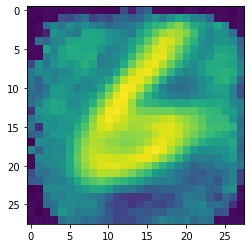

In [ ]:
a_6_3=vae_test()
plt.imshow(a_6_3)

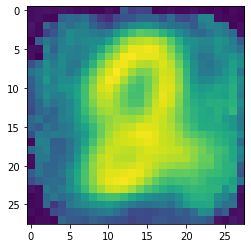

In [ ]:
a_8_1=vae_test()
plt.imshow(a_8_1)

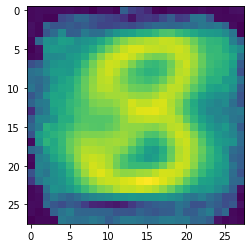

In [ ]:
a_8_2=vae_test()
plt.imshow(a_8_2)

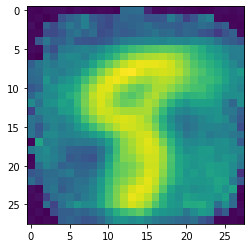

In [ ]:
a_8_3=vae_test()
plt.imshow(a_8_3)

(-0.5, 27.5, 27.5, -0.5)

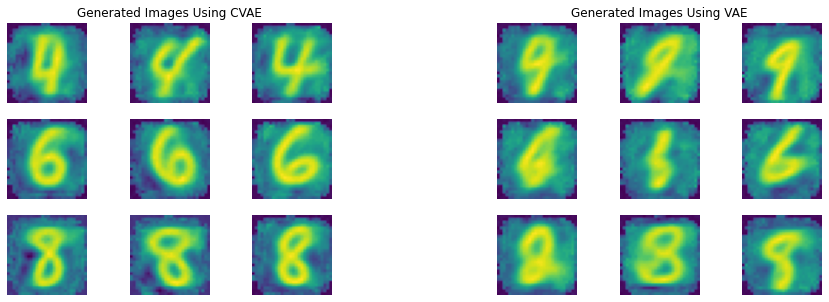

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)


plt.subplot(3,7,1)
cpred(4)
plt.axis('off')
plt.subplot(3,7,2)
cpred(4)
plt.title('Generated Images Using CVAE')
plt.axis('off')
plt.subplot(3,7,3)
cpred(4)
plt.axis('off')
plt.subplot(3,7,8)
cpred(6)
plt.axis('off')
plt.subplot(3,7,9)
cpred(6)
plt.axis('off')
plt.subplot(3,7,10)
cpred(6)
plt.axis('off')
plt.subplot(3,7,15)
cpred(8)
plt.axis('off')
plt.subplot(3,7,16)
cpred(8)
plt.axis('off')
plt.subplot(3,7,17)
cpred(8)
plt.axis('off')

plt.subplot(3,7,5)
plt.imshow(a_4_1)
plt.axis('off')
plt.subplot(3,7,6)
plt.imshow(a_4_2)
plt.title('Generated Images Using VAE')
plt.axis('off')
plt.subplot(3,7,7)
plt.imshow(a_4_3)
plt.axis('off')
plt.subplot(3,7,12)
plt.imshow(a_6_1)
plt.axis('off')
plt.subplot(3,7,13)
plt.imshow(a_6_2)
plt.axis('off')
plt.subplot(3,7,14)
plt.imshow(a_6_3)
plt.axis('off')
plt.subplot(3,7,19)
plt.imshow(a_8_1)
plt.axis('off')
plt.subplot(3,7,20)
plt.imshow(a_8_2)
plt.axis('off')
plt.subplot(3,7,21)
plt.imshow(a_8_3)
plt.axis('off')